In [1]:
import sys
import spikeinterface as si
import matplotlib.pyplot as plt
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import probeinterface

from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup
from probeinterface import generate_dummy_probe, generate_linear_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb
import os
import numpy as np
from spikeinterface.core import concatenate_recordings

/home/ubuntu/.conda/envs/spike_sorting_jct/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_list = os.listdir("/media/ubuntu/sda/littlerat/raw_data/rhs")
folder_list.remove("20250616littlerat_3_250616_103529")
folder_list.remove("20250616littlerat_3_250616_103936")
folder_list.remove("20250616littlerat_8_250616_141100")
folder_list.remove("20250616littlerat_8_250616_141414")
folder_list.remove("20250618littlerat_6_250618_094330")
folder_list.remove("20250618littlerat_10_250618_134734")



In [4]:
for folder in folder_list:
    file_list = os.listdir(f"/media/ubuntu/sda/littlerat/raw_data/rhs/{folder}")
    file_list.remove("settings.xml")
    recording_raw_list = []
    for file in file_list:
        recording_raw_list.append(se.read_intan(f"/media/ubuntu/sda/littlerat/raw_data/rhs/{folder}/{file}", stream_id= '0'))
    recording_raw = concatenate_recordings(recording_list=recording_raw_list)
    probe = read_probeinterface("/media/ubuntu/sda/pancreas/single_electrode_probe.json")

    print("Start Spike Sorting...")
    recording_channel = recording_raw.channel_slice(['A-015', 'A-031'])
    recording_channel = recording_channel.set_probegroup(probe)

    recording_f = spre.bandpass_filter(recording_channel, freq_min=300, freq_max=3000)
    recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
    recording_preprocessed = recording_cmr.save(format="binary")

    os.makedirs(f'/media/ubuntu/sda/littlerat/spike_sorted/single_channel/{folder}', exist_ok=True)
    output_folder = f'/media/ubuntu/sda/littlerat/spike_sorted/single_channel/{folder}/channel'
    sorting_kilosort4 = ss.run_sorter(sorter_name="kilosort4", recording=recording_preprocessed, output_folder=output_folder + "/kilosort4")
    analyzer_kilosort4 = si.create_sorting_analyzer(sorting=sorting_kilosort4, recording=recording_preprocessed, format='binary_folder', folder=output_folder + '/analyzer_kilosort4_binary')

    extensions_to_compute = [
        "random_spikes",
        "waveforms",
        "noise_levels",
        "templates",
        "spike_amplitudes",
        "unit_locations",
        "spike_locations",
        "correlograms",
        "template_similarity"
    ]

    extension_params = {
        "unit_locations": {"method": "center_of_mass"},
        "spike_locations": {"ms_before": 0.1},
        "correlograms": {"bin_ms": 0.1},
        "template_similarity": {"method": "cosine_similarity"}
    }

    analyzer_kilosort4.compute(extensions_to_compute, extension_params=extension_params)

    qm_params = sqm.get_default_qm_params()
    analyzer_kilosort4.compute("quality_metrics", qm_params)

    import spikeinterface.exporters as sexp
    sexp.export_to_phy(analyzer_kilosort4, output_folder + "/phy_folder_for_kilosort", verbose=True)


KeyboardInterrupt: 

In [80]:
for file in file_list:
    recording_raw = se.read_binary(f"/media/ubuntu/sda/littlerat/raw_data/merged_data/{file}", sampling_frequency= 20000, dtype=np.float32, num_channels=32)
    recording_recorded = recording_raw.remove_channels([17, 18])

    probe_30channel = read_probeinterface('/media/ubuntu/sda/littlerat/tetrode_probe.json')
    recording_recorded = recording_recorded.set_probegroup(probe_30channel)

    recording_cmr = recording_recorded
    recording_f = spre.bandpass_filter(recording_recorded, freq_min=300, freq_max=3000)
    print(recording_f)
    recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
    print(recording_cmr)

    # this computes and saves the recording after applying the preprocessing chain
    recording_preprocessed = recording_cmr.save(format="binary")
    print(recording_preprocessed)

    output_folder = f'/media/ubuntu/sda/littlerat/spike_sorted/tetrode/{file.split(".")[0]}'
    sorting_kilosort4 = ss.run_sorter(sorter_name="kilosort4", recording=recording_preprocessed, output_folder=output_folder + "/kilosort4")
    analyzer_kilosort4 = si.create_sorting_analyzer(sorting=sorting_kilosort4, recording=recording_preprocessed, format='binary_folder', folder=output_folder + '/analyzer_kilosort4_binary')

    extensions_to_compute = [
        "random_spikes",
        "waveforms",
        "noise_levels",
        "templates",
        "spike_amplitudes",
        "unit_locations",
        "spike_locations",
        "correlograms",
        "template_similarity"
    ]

    extension_params = {
        "unit_locations": {"method": "center_of_mass"},
        "spike_locations": {"ms_before": 0.1},
        "correlograms": {"bin_ms": 0.1},
        "template_similarity": {"method": "cosine_similarity"}
    }

    analyzer_kilosort4.compute(extensions_to_compute, extension_params=extension_params)

    qm_params = sqm.get_default_qm_params()
    analyzer_kilosort4.compute("quality_metrics", qm_params)

    import spikeinterface.exporters as sexp
    sexp.export_to_phy(analyzer_kilosort4, output_folder + "/phy_folder_for_kilosort", verbose=True)

FileNotFoundError: [Errno 2] No such file or directory: '/media/ubuntu/sda/littlerat/raw_data/merged_data/20250616littlerat_8_250616_141100.rhs'

In [62]:
#recording_raw = se.read_binary(f"/media/ubuntu/sda/littlerat/raw_data/merged_data/20250616littlerat_12_250616_170910.bin", sampling_frequency= 20000, dtype=np.float32, num_channels=32)
recording_recorded = recording_raw.remove_channels([17, 18])

probe_30channel = read_probeinterface('/media/ubuntu/sda/littlerat/tetrode_probe.json')
recording_recorded = recording_recorded.set_probegroup(probe_30channel)

recording_cmr = recording_recorded
recording_f = spre.bandpass_filter(recording_recorded, freq_min=300, freq_max=750)
print(recording_f)
recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
print(recording_cmr)

# this computes and saves the recording after applying the preprocessing chain
#recording_preprocessed = recording_cmr.save(format="binary")
#print(recording_preprocessed)

ValueError: `remove_channel_ids` [17, 18] are not in recording ids ['A-000' 'A-001' 'A-002' 'A-003' 'A-004' 'A-005' 'A-006' 'A-007' 'A-008'
 'A-009' 'A-010' 'A-011' 'A-012' 'A-013' 'A-014' 'A-015' 'A-016' 'A-017'
 'A-018' 'A-019' 'A-020' 'A-021' 'A-022' 'A-023' 'A-024' 'A-025' 'A-026'
 'A-027' 'A-028' 'A-029' 'A-030' 'A-031'].

In [57]:
a = recording_raw.get_traces(start_frame=0, end_frame=2000).T

<Axes: >

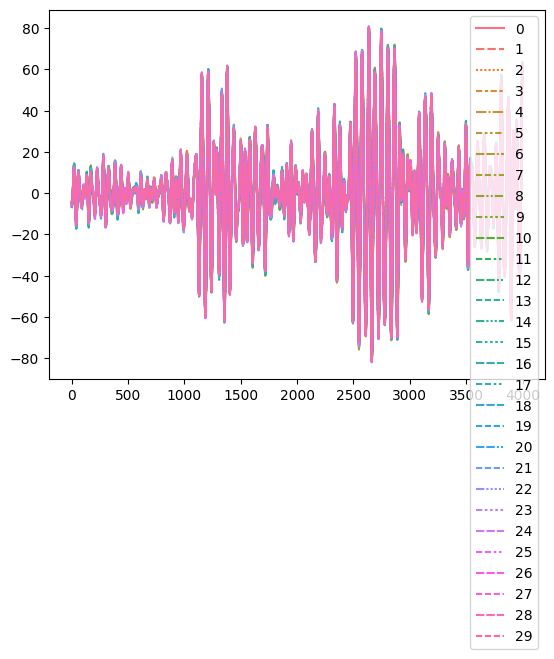

In [53]:
import seaborn as sns

sns.lineplot(recording_f.get_traces(start_frame=4000, end_frame=8000))


In [48]:
recording_f.get_traces(start_frame=2000, end_frame=4000).shape

(2000, 30)